# 0. Download the WordNet Dataset

In [1]:
# Do this once
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cashewmake/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from nltk.corpus import wordnet as wn
import numpy as np
import pandas as pd

# 1. Define Functions

### 1.1 Extract and Format WordNet Data

In [3]:
def generate_synset_dicts(synset_root):
    """Construct a collection of synset:hyponyms mappings starting from a root node."""
    synset_dicts = []
    
    def make_row(x, level = 0):
        """Create a dictionary for a given synset in order to add it to a dataframe."""
        return {'str_synset': x.name(), 'hyponyms': [hyp.name() for hyp in x.hyponyms()], 'level': level}

    def get_hyponym_tree(synset, level = 0):
        """Traverse the synset hyponym tree recursively to add new nodes."""
        if len(synset.hyponyms()) == 0:
            row = make_row(synset, level)
            row['hyponyms'] = None
            synset_dicts.append(row)
        else:
            row = make_row(synset, level)
            synset_dicts.append(row)
            [get_hyponym_tree(shi, level + 1) for shi in synset.hyponyms()]
            
    get_hyponym_tree(synset_root)
    return synset_dicts


def generate_synset_df(synset_root):
    """Construct a dataframe from the synset hyponym tree."""
    synset_dicts = generate_synset_dicts(synset_root)

    # Arrange synsets into a pandas dataframe
    df = pd.DataFrame(synset_dicts)
    df = df.drop_duplicates(subset = 'str_synset')
    df = df.sort_values(by = 'str_synset').reset_index(drop = True)
    df = df.reset_index().rename(columns = {'index': 'ind'})
    df = df.set_index('str_synset')
    df['D'] = ~df.hyponyms.isna()
    df.loc[df.D == True,'numeric_synset'] = df[df.D == True].hyponyms.apply(lambda x: [df.loc[xi].ind for xi in x])
    df.loc[df.D == False,'numeric_synset'] = None
    return df

### 1.2 Preprocessing

In [4]:
def generate_D(df):
    """Generate a collection of relations between each u pt and its v pts."""
    df_D = df[df.D == True]
    return [pt for pt in zip(df_D.ind, df_D.numeric_synset)]


def generate_Nu(D, Nu_n_samples = 10):
    """Generate a collection of random negative samples for each (u,v) in D."""
    Nu = {}
    for (u_ind, v_inds) in D:
        Nu_inds = (set(range(0,len(D))).difference(set(v_inds))).union(set([u_ind]))
        sample_inds = lambda x: list(np.random.choice(list(x), size = Nu_n_samples, replace = False))
        vp_inds_lists = [sample_inds(Nu_inds) for i in range(0,len(v_inds))]
        Nu[u_ind] = vp_inds_lists
    return Nu

### 1.3 Poincare Ball Functions

In [5]:
def d(u,v):
    """Compute the distance between two points in the Poincare Ball."""
    num = np.linalg.norm(u - v, axis = 0)**2
    denom = (1 - np.linalg.norm(u, axis = 0)**2) * (1 - np.linalg.norm(v, axis = 0)**2)
    return np.arccosh(1 + (2*(num / denom)))

### 1.4 Optimization: Loss, Gradient, and RSGD

In [6]:
def L(x, D, Nu):
    """Compute the loss associated with the current embedding of the dataset.
    
    Parameters
    ----------
    x : np.array, shape={dimension, num_points}
        Embedding coordinates for each point in the data. 
        
    D : list of lists, shape={num_points, num_connections}
        Container relating a point (word) u to its connected points (words) vs.
    """
    loss = 0
    for (u_ind, v_inds) in D:
        # Numerator: Positive Pairs
        u = x[:, u_ind].reshape(-1,1)
        vs = x[:, v_inds].reshape(-1,len(v_inds))
        numerators = np.exp(-d(u,vs))

        # Denominator: Negative Pairs
        vp_inds_lists = Nu[u_ind]
        compute_denominator = lambda v_inds: np.sum(np.exp(-d(u, x[:,v_inds])))
        denominators = np.array([compute_denominator(vp_inds) for vp_inds in vp_inds_lists]).reshape(1,-1)
        loss += np.sum(np.log(numerators / denominators))
    return loss  


def dp(u,v):
    """Compute the gradient of d wrt u."""
    a = 1 - np.linalg.norm(u, axis = 0)**2
    b = 1 - np.linalg.norm(v, axis = 0)**2
    gm = 1 + 2*np.linalg.norm(u-v, axis = 0)**2 / (a*b)
    du = 4*((u*(np.linalg.norm(v, axis = 0)**2 - 2*np.dot(u.T,v) + 1) / a**2) - (v/a)) / (b*np.sqrt(gm**2 - 1))
    return du


def grad_u(x, D, Nu):
    """Compute the gradient for all u points."""
    ### TODO
    return 0.1*(1 - 2*np.random.rand(*x.shape))
#     x_u_grad = np.zeros_like(x)
#     dim = x.shape[0]

#     for (u_ind, v_inds) in D:
#         u = x[:, u_ind].reshape(-1,1)
#         vs = x[:, v_inds].reshape(-1,len(v_inds))

#         dpsum = np.sum(-dp(u,vs), axis = 1, keepdims = True)
#         vp_inds_lists = Nu[u_ind]
#         compute_num = lambda u, vp: np.sum( dp(u, vp.reshape(dim, -1)) * np.exp(-d(u, vp.reshape(dim, -1))), axis = 1,  keepdims = True)
#         compute_denom = lambda u, vp: np.sum( np.exp(-d(u, vp.reshape(dim,-1))) )
 
#         neg_terms = [compute_num(u, x[:,vps]) / compute_denom(u, x[:,vps]) for vps in vp_inds_lists]
#         dp_Nu = np.sum(np.concatenate(neg_terms, axis = 1), axis = 1, keepdims = True)
#         x_u_grad[:, u_ind] = dp_Nu.T
#     return x_u_grad
        
    
def grad_v(x, D, Nu):
    """Compute the gradient for all v coordinates."""
    ### TODO
    return np.zeros_like(x)


def grad_vp(x, D, Nu):
    """Compute the gradient for all vp (vprime) coordinates."""
    ### TODO
    return np.zeros_like(x)


def grad_E(x, D, Nu):
    """Compute the Euclidean gradient using the three coordinate group gradients."""
    ### TODO
    # Update u
    x_grad_u = grad_u(x, D, Nu)
    
    # Update v
    x_grad_v = grad_v(x, D, Nu)

    # Update v'
    x_grad_vp = grad_vp(x, D, Nu)
    
    grad = x_grad_u + x_grad_v + x_grad_vp
    return grad


def proj(x, epsilon = 1E-4):
    """Rescale the point to ensure that it lies within the Poincare Ball."""
    norm_x = np.linalg.norm(x, axis = 0, keepdims = True)
    return np.where(norm_x >= 1, x/norm_x - epsilon, x)


def rgd(x0, D, num_iter, nu = 10, c = 1):
    """Perform Riemannian Stochastic Gradient Descent."""
    losses = []
    xts = []
    xt = x0
    nt = nu/c
    xts.append(x0)
    for i in range(0,num_iter):
        Nu = generate_Nu(D)
        g_pb_inv = ((1 - np.linalg.norm(xt, axis = 0)**2)**2)/4
        xt = proj(xt - nt*g_pb_inv*grad_E(xt, D, Nu))
        loss = L(xt, D, Nu)
        losses.append(loss)
        print('Iteration: ' + str(i))
        print('Loss: ' + str(loss))
        xts.append(xt)
    return xts, losses

# 2. Initialize Problem

In [7]:
mammal = wn.synset('mammal.n.01')
print(mammal)
print('Hyponyms:') 
print(mammal.hyponyms())
print('Hypernyms:')
print(mammal.hypernyms())

Synset('mammal.n.01')
Hyponyms:
[Synset('female_mammal.n.01'), Synset('fossorial_mammal.n.01'), Synset('metatherian.n.01'), Synset('placental.n.01'), Synset('prototherian.n.01'), Synset('tusker.n.01')]
Hypernyms:
[Synset('vertebrate.n.01')]


In [8]:
df = generate_synset_df(mammal)
df

,ind,hyponyms,level,D,numeric_synset
str_synset,,,,,
aardvark.n.01,0,None,2,False,None
aardwolf.n.01,1,None,5,False,None
aberdeen_angus.n.01,2,None,9,False,None
abrocome.n.01,3,None,3,False,None
abyssinian.n.01,4,None,6,False,None
...,...,...,...,...,...
yorkshire_terrier.n.01,1165,None,7,False,None
zebra.n.01,1166,"[common_zebra.n.01, grevy's_zebra.n.01, mounta...",5,True,"[252, 442, 687]"
zebu.n.01,1167,None,8,False,None


In [9]:
scale = 0.1
n_points = df.shape[0]
x0 = scale * (1 - 2*np.random.rand(2 , n_points))
D = generate_D(df)

# 3. Optimize to Find Poincare Embeddings

In [10]:
# Not yet completed
xts, losses = rgd(proj(x0), D = D, num_iter = 40)

Iteration: 0
Loss: -2734.584049905395
Iteration: 1
Loss: -2765.017948908191
Iteration: 2
Loss: -2798.8743013317285
Iteration: 3
Loss: -2831.469152872787
Iteration: 4
Loss: -2856.296915122606
Iteration: 5
Loss: -2888.589235518963
Iteration: 6
Loss: -2900.056289347544
Iteration: 7
Loss: -2923.5932760017527
Iteration: 8
Loss: -2938.6732221534267
Iteration: 9
Loss: -2950.414012832103
Iteration: 10
Loss: -2972.8041741838583
Iteration: 11
Loss: -2971.9892353179744
Iteration: 12
Loss: -2968.5868034440177
Iteration: 13
Loss: -2978.4606082707382
Iteration: 14
Loss: -2982.9468896192284
Iteration: 15
Loss: -3016.723763445375
Iteration: 16
Loss: -3021.3165714491083
Iteration: 17
Loss: -3037.615970943317
Iteration: 18
Loss: -3047.955702400457
Iteration: 19
Loss: -3045.206178342194
Iteration: 20
Loss: -3102.222596310217
Iteration: 21
Loss: -3088.2011995862863
Iteration: 22
Loss: -3111.2324497539685
Iteration: 23
Loss: -3106.9778820620986
Iteration: 24
Loss: -3127.945082618455
Iteration: 25
Loss: -31

In [11]:
xf = xts[-1]

# 4. Visualization 

### 4.1 Visualize the Embeddings Throughout the Optimization Process

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as pt
from ipywidgets import interact
import ipywidgets as widgets

In [13]:
def plot_x(x):
    fig, ax = plt.subplots(figsize=(10, 10))
    circle = pt.Circle((0, 0), 1, facecolor='none', edgecolor=(0, 0, 0), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
    plt.scatter(x[0,:], x[1,:], s=1)
    plt.title("Hyperbolic Embedding of WordNet Synsets in the Poincare Ball")
    plt.show()

    
f = lambda t: plot_x(x = xts[t])
interact(f,t = widgets.IntSlider(min = 0, max = len(xts)-1, step = 1, continuous_update = False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=40), Output()), _dom_cl…

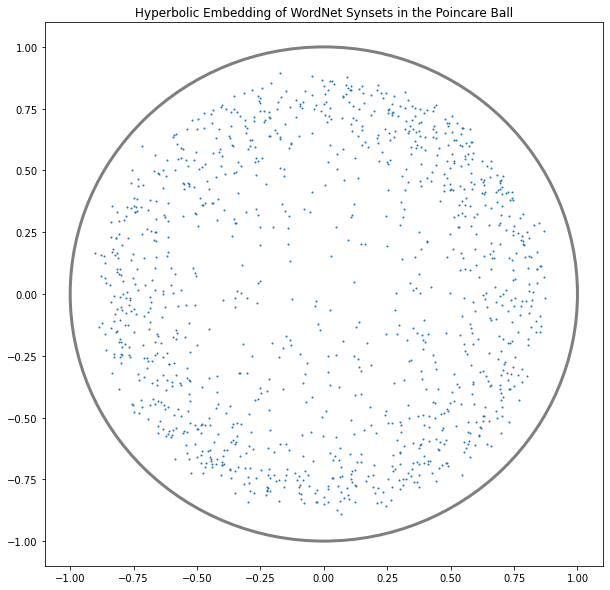

In [37]:
plot_x(xts[-1])

### 4.2 Visualize Subtrees from WordNet with Networkx
TODO

In [14]:
import networkx as nx
from matplotlib import cm

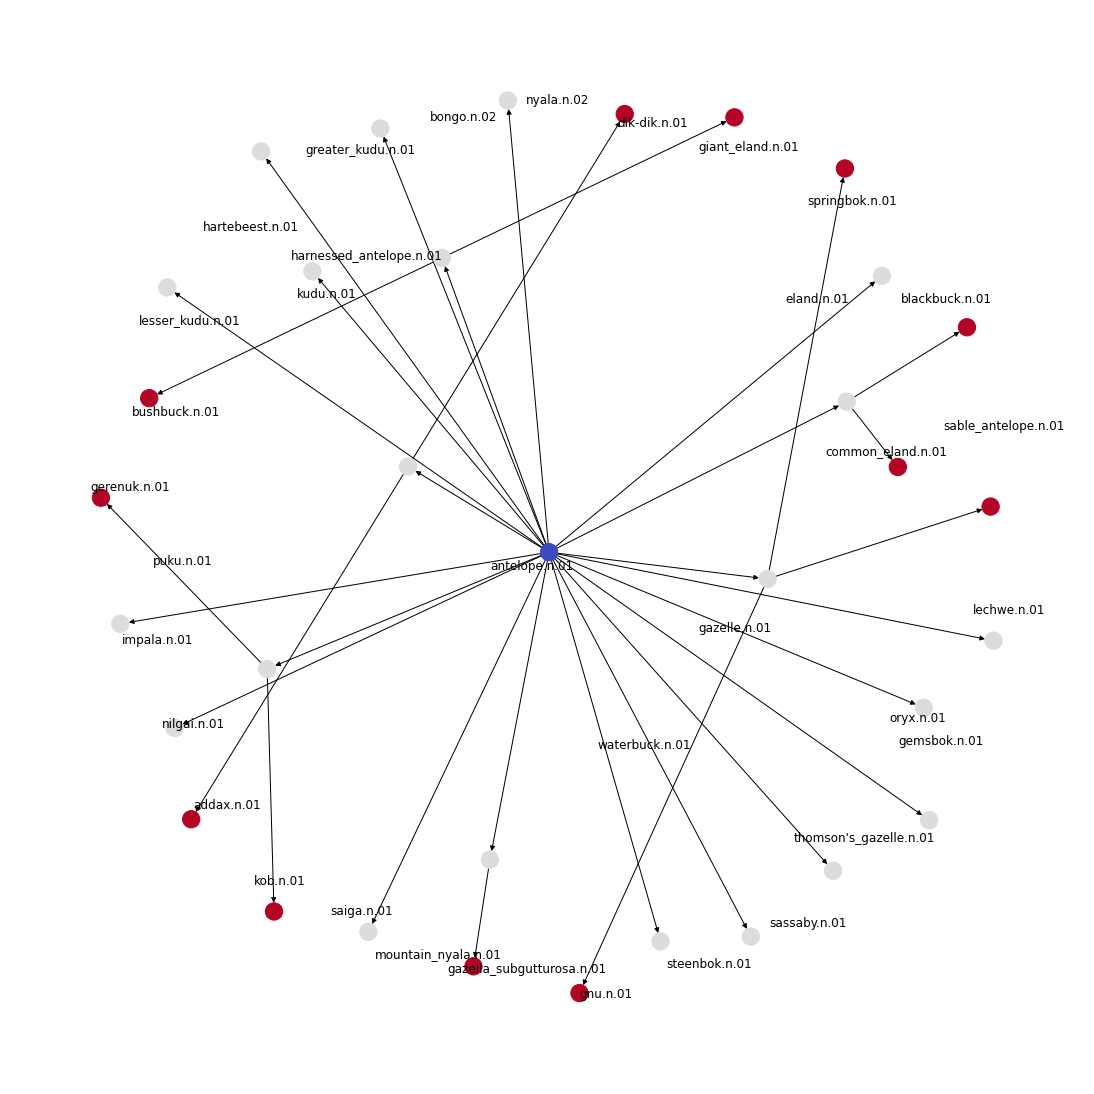

In [36]:
# def display_subtrees_nx(synset_root):
#     """Display the synset subtrees beginning from a synset root."""
synset_root = wn.synset('antelope.n.01')
df = generate_synset_df(synset_root)
max_level = df.level.max()
D = generate_D(df)
dg = nx.DiGraph()
for (u_ind, v_inds) in D:
    dg.add_edges_from([(u_ind, v_ind) for v_ind in v_inds])

labels = {}    
color_map = []
for node in dg.nodes():
    labels[node] = df.iloc[node].name
    color_map.append(cm.coolwarm(float(df.level[node])/max_level))

fig = plt.figure(figsize = (15,15))
nx.draw(dg, with_labels=False, node_color=color_map)
labeled_nodes = nx.draw_networkx_labels(dg, pos = nx.spring_layout(dg), labels = labels)

# 5. Explore Embedding Performance

TODO

# 6. Additional Sanity Checks

### Test the partial derivative of the distance function with respect to u or v

In [17]:
u = 1*(2-np.random.rand(2,1))
v = 1*(2-np.random.rand(2,1))

delta = 1E-8
# wrt u
print('u')
print(np.dot(np.ones((2,1)).T, dp(u, v)))
print((d(u+delta, v) - d(u, v))/delta)

# wrt v
print('v')
print(np.dot(np.ones((2,1)).T,dp(v,u)))
print((d(u, v+delta) - d(u, v))/delta)

u
[[-0.85851175]]
[-0.85851175]
v
[[-0.02266943]]
[-0.02266943]


### Test the Euclidean gradient of the loss function

TODO: Fix/Finish implementing the gradient

Currently the gradient is just a low-magnitude random vector, so these numbers won't be close

In [18]:
mammal = wn.synset('mammal.n.01')
df = generate_synset_df(mammal)
scale = 0.5
n_points = df.shape[0]
x0 = scale * (1 - 2*np.random.rand(2 , n_points).astype(np.float64))
D = generate_D(df)
Nu = generate_Nu(D, Nu_n_samples=10)

dx0 = 1E-6
print('True Loss Slope: ' + str((L(x0 + dx0*np.ones_like(x0), D, Nu) - L(x0, D, Nu))/dx0))
print('grad_E Slope: ' + str(np.dot(np.ones((2,n_points)).flatten().T, grad_E(x0, D, Nu).flatten())))
# I need to fix the gradient step: I'm getting divide by zero / np.inf values out!
# For now I've replaced the gradient with random values to test this issue
# These will not equal each other!

True Loss Slope: 2.0126499293837696
grad_E Slope: -6.281831352044364


TODO: Fix the gradient method so that I don't have any more np.infs!

In [19]:
ge = grad_E(x0, D, Nu)
ge[ge == np.inf]

array([], dtype=float64)